In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
train = pd.read_csv('/kaggle/input/titanic/train.csv', sep=',')
test = pd.read_csv('/kaggle/input/titanic/test.csv', sep=',')

In [4]:
test_ids = test['PassengerId']

In [5]:
# from ydata_profiling import ProfileReport
# profile = ProfileReport(train, title="Profiling Report")
# profile.to_notebook_iframe()

### Drop unnecessary columns:
- Name
- Ticket
- Cabin
- PassengerId

In [6]:
train.drop(columns=['Name','Ticket','Cabin','PassengerId'],inplace=True)
test.drop(columns=['Name','Ticket','Cabin','PassengerId'],inplace=True)

In [7]:
# train['Sex'].replace('female',0,inplace=True)
# train['Sex'].replace('male',1,inplace=True)

### Impute Missing Values in Age

In [8]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
# Iterative Imputation
iter_imputer = IterativeImputer(random_state=42)
iter_imputer.fit(np.array(train['Age']).reshape(-1, 1))
train['Age'] = iter_imputer.transform(np.array(train['Age']).reshape(-1, 1))
test['Age'] = iter_imputer.transform(np.array(test['Age']).reshape(-1, 1))

imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
imp_median.fit(np.array(train['Fare']).reshape(-1, 1))
train['Fare'] = imp_median.transform(np.array(train['Fare']).reshape(-1, 1))
test['Fare'] = imp_median.transform(np.array(test['Fare']).reshape(-1, 1))

In [9]:
Y_train = train.loc[:, train.columns == 'Survived']
X_train = train.loc[:, train.columns != 'Survived']
X_test = test

In [10]:
cols_to_encode = [
                    "Sex",
                    "Embarked"
                ]
X_train = pd.get_dummies(X_train, columns = cols_to_encode)
X_test = pd.get_dummies(X_test, columns = cols_to_encode)
# X = X.drop(cols_to_encode, axis=1)
# X = pd.concat([X, dummies], axis=1)

In [11]:
X_train.skew()

Pclass       -0.630548
Age           0.434488
SibSp         3.695352
Parch         2.749117
Fare          4.787317
Sex_female    0.618921
Sex_male     -0.618921
Embarked_C    1.595149
Embarked_Q    2.948778
Embarked_S   -0.997083
dtype: float64

In [12]:
X_test['Fare'].isnull().values.any()

False

In [13]:
from sklearn.preprocessing import QuantileTransformer
qt = QuantileTransformer(n_quantiles=302, output_distribution='normal')
qt.fit(np.array(X_train['Fare']).reshape(-1, 1))
X_train.loc[:,'Fare'] = qt.transform(np.array(X_train['Fare']).reshape(-1, 1))
X_test.loc[:,'Fare'] = qt.transform(np.array(X_test['Fare']).reshape(-1, 1))

In [14]:
from sklearn.preprocessing import StandardScaler
columns = X_train.columns

#data preprocessing
numeric_columns = ['Age', 'Fare']

# Create a StandardScaler instance
scaler = StandardScaler()
# features = X_train[col_names]
# scaler = StandardScaler().fit(features.values)
# features = scaler.transform(features.values)

# Fit the scaler on the data and transform the selected columns
scaler.fit(X_train[numeric_columns])
X_train.loc[:,numeric_columns] = scaler.transform(X_train[numeric_columns])
X_train.columns = columns
X_test.loc[:,numeric_columns] = scaler.transform(X_test[numeric_columns])
X_test.columns = columns

In [15]:
X_train

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,-0.592481,1,0,-1.124773,False,True,False,False,True
1,1,0.638789,1,0,1.038392,True,False,True,False,False
2,3,-0.284663,0,0,-0.507636,True,False,False,False,True
3,1,0.407926,1,0,0.865072,True,False,False,False,True
4,3,0.407926,0,0,-0.420068,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...
886,2,-0.207709,0,0,-0.059456,False,True,False,False,True
887,1,-0.823344,0,0,0.558494,True,False,False,False,True
888,3,0.000000,1,2,0.271693,True,False,False,False,True
889,1,-0.284663,0,0,0.558494,False,True,True,False,False


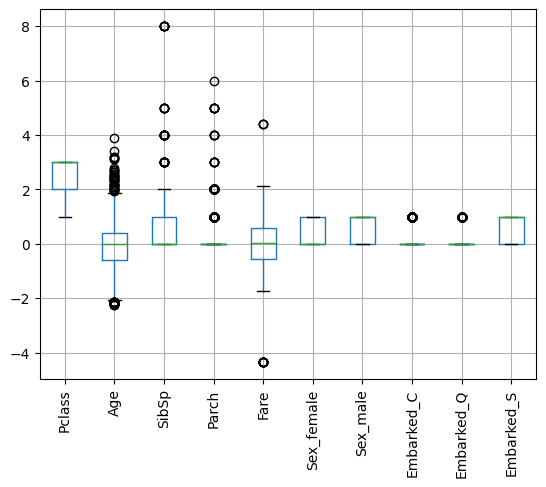

In [16]:
boxplot = X_train.boxplot() 
plt.xticks(rotation=90);

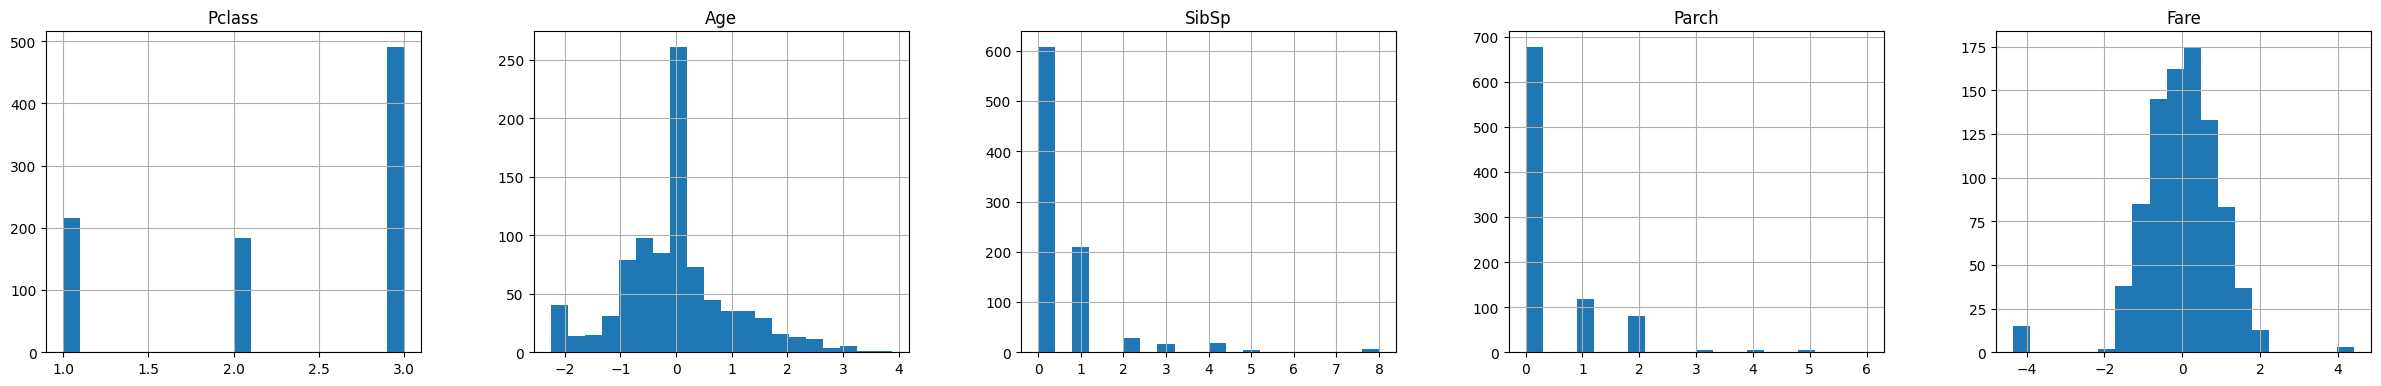

In [17]:
X_train.hist(figsize=(30,15), bins = 20, layout=(3,5));

In [18]:
print(Y_train.value_counts())

Survived
0           549
1           342
Name: count, dtype: int64


In [19]:
from sklearn.model_selection import train_test_split
X_train_temp, X_test_temp, Y_train_temp, Y_test_temp = train_test_split(X_train, Y_train, test_size=0.33, random_state=42)

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import make_pipeline

names = [
    "Logistic Regression",
    "SVC",
    "Random Forest",
    "Multi-Layer Perceptron",
    "GaussianNB",
    "XGB",
    "LightGBM",
    "CatBoost",
]

classifiers = [
    LogisticRegression(),
    SVC(),
    RandomForestClassifier(),
    MLPClassifier(),
    GaussianNB(),
    XGBClassifier(),
    LGBMClassifier(),
    CatBoostClassifier(verbose=0),
    #CatBoostClassifier(verbose=0, n_estimators=35, max_depth=6),
    
]

for name, clf in zip(names, classifiers):
        clf = make_pipeline(StandardScaler(), clf)
        clf.fit(X_train_temp, Y_train_temp.values.ravel())
        score = clf.score(X_test_temp, Y_test_temp.values.ravel())
        print(name, ": ", score)

Logistic Regression :  0.8135593220338984
SVC :  0.823728813559322
Random Forest :  0.7830508474576271


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Multi-Layer Perceptron :  0.8169491525423729
GaussianNB :  0.7728813559322034
XGB :  0.7864406779661017
LightGBM :  0.8203389830508474
CatBoost :  0.8135593220338984


In [21]:
clf = SVC()
clf.fit(X_train, Y_train.values.ravel())
survived = clf.predict(X_test)


In [22]:
final = pd.DataFrame(columns=['PassengerId','Survived'])
final['PassengerId'] = test_ids
final['Survived'] = survived
final.to_csv()

',PassengerId,Survived\n0,892,0\n1,893,1\n2,894,0\n3,895,0\n4,896,1\n5,897,0\n6,898,1\n7,899,0\n8,900,1\n9,901,0\n10,902,0\n11,903,0\n12,904,1\n13,905,0\n14,906,1\n15,907,1\n16,908,0\n17,909,0\n18,910,1\n19,911,1\n20,912,0\n21,913,0\n22,914,1\n23,915,0\n24,916,1\n25,917,0\n26,918,1\n27,919,0\n28,920,0\n29,921,0\n30,922,0\n31,923,0\n32,924,0\n33,925,0\n34,926,0\n35,927,0\n36,928,1\n37,929,1\n38,930,0\n39,931,0\n40,932,0\n41,933,0\n42,934,0\n43,935,1\n44,936,1\n45,937,0\n46,938,0\n47,939,0\n48,940,1\n49,941,1\n50,942,0\n51,943,0\n52,944,1\n53,945,1\n54,946,0\n55,947,0\n56,948,0\n57,949,0\n58,950,0\n59,951,1\n60,952,0\n61,953,0\n62,954,0\n63,955,1\n64,956,1\n65,957,1\n66,958,1\n67,959,0\n68,960,0\n69,961,0\n70,962,1\n71,963,0\n72,964,1\n73,965,0\n74,966,1\n75,967,0\n76,968,0\n77,969,1\n78,970,0\n79,971,1\n80,972,1\n81,973,0\n82,974,0\n83,975,0\n84,976,0\n85,977,0\n86,978,1\n87,979,1\n88,980,1\n89,981,1\n90,982,1\n91,983,0\n92,984,1\n93,985,0\n94,986,0\n95,987,0\n96,988,1\n97,989,0\n98,990